In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import illustris_python as il
import os


In [2]:
def masses(df):
    keys = df.keys()
    for key in keys:
        if "Mass" in key:
            df[key] = df[key]*10**10
    return df

def color(df):
    df["SubhaloColor_g-i"] = df["SubhaloStellarPhotometrics_g"] - df["SubhaloStellarPhotometrics_i"]
    return df

In [3]:
def late_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names)
    """
    index_names_1 = df_copy[df_copy["SubhalosSFR"] > 0.36].index
    df_copy = df_copy.drop(index_names_1)
    index_names_2 = df_copy[df_copy["SubhalosSFR"] < 0.036].index
    df_copy = df_copy.drop(index_names_2)
    """
    return df_copy

def early_type_SFR(df):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR"] > 0.01148].index
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_gas(df):
    df_copy = df.copy(deep=True)
    df_copy["SubhaloGasFraction"] = df_copy["SubhaloMassGas"]/df_copy["SubhaloMassStellar"]
    index_names = df_copy[df_copy["SubhaloGasFraction"] < 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_gas(df):
    df_copy = df.copy(deep=True)
    df_copy["SubhaloGasFraction"] = df_copy["SubhaloMassInRadGas"]/df_copy["SubhaloMassInRadStellar"]
    index_names = df_copy[df_copy["SubhaloGasFraction"] > 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy


In [4]:
old = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE9_5_SM.pkl")
new = pd.read_pickle("../data/tng-100-1/catalogues/kappa_rot_2502.pkl")

print(len(old), len(new))

#Masses
old = masses(old)
new = masses(new)

#sSFR
new["SubhalosSFR"] = 10**(9)*new["SubhaloSFR"]/new["SubhaloMassStellar"]
new["SubhaloGasFraction"] = new["SubhaloMassGas"]/new["SubhaloMassStellar"]

#Adding color
new = color(new)
old = color(old)


5877 5855


In [5]:
import h5py
result = {}
with h5py.File("../data/tng-100-3/catalogues/stellar_circs.hdf5", "r") as f:
    header = dict(f['Header'].attrs.items())
    fields = list(f["Snapshot_99"].keys())
    for field in fields:
        result[field] = np.array(f["Snapshot_99"][field])
    kinematics = result
print(kinematics["SpecificAngMom"])

[12610.998     1418.9609    2682.5693   ...    42.777134   221.87273
   341.50983 ]


In [6]:
#Make sure the same galaxies are selected, create late/early type catalogues
old_earlies = early_type_SFR(early_type_gas(old))
old_lates = late_type_SFR(late_type_gas(old))
earlies_id = list(old_earlies["id"].values)
lates_id = list(old_lates["id"].values)
ids = list(old["id"].values)

new_earlies = new[new["id"].isin(earlies_id)]
new_lates = new[new["id"].isin(lates_id)]
new = new[new["id"].isin(ids)]
earlies_new_id = list(new_earlies["id"].values)
lates_new_id = list(new_lates["id"].values)
new_ids = list(new["id"].values)

old_earlies = old[old["id"].isin(earlies_new_id)]
old_lates = old[old["id"].isin(lates_new_id)]
old = old[old["id"].isin(new_ids)]

In [7]:
#Log format
new_log = il.formatplot.log_formater(new)
old_log = il.formatplot.log_formater(old)
new_earlies_log = il.formatplot.log_formater(new_earlies)
old_earlies_log = il.formatplot.log_formater(old_earlies)
new_lates_log = il.formatplot.log_formater(new_lates)
old_lates_log = il.formatplot.log_formater(old_lates)

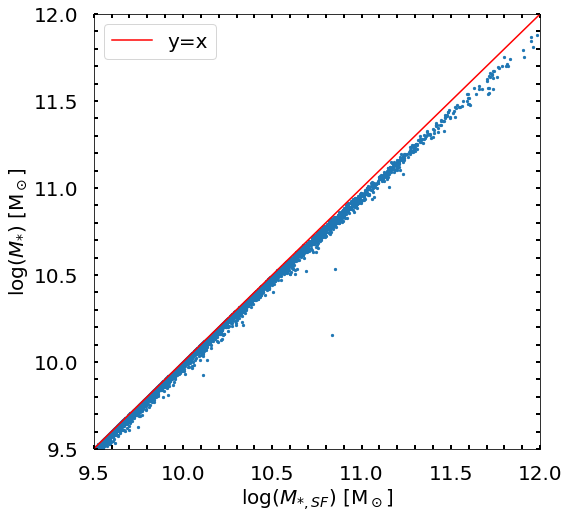

In [8]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
new_vals_log = new_log["SubhaloMassStellar"].values

axs.scatter(old_vals_log, new_vals_log, s=5)

x = np.linspace(0, 12)
axs.plot(x, x, c="red", label = "y=x")

il.formatplot.SM_SM(ax=axs)


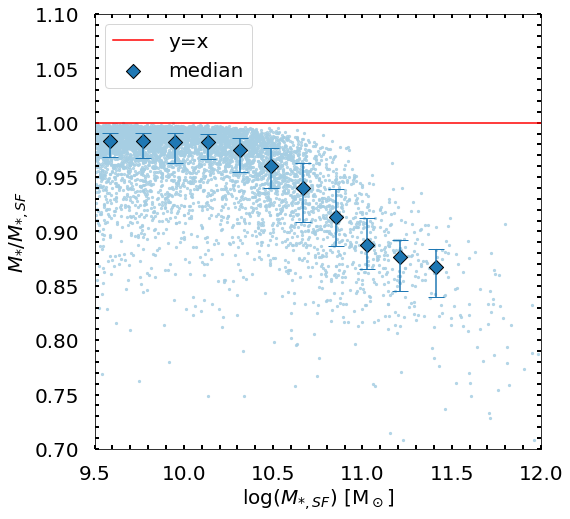

In [9]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = old["SubhaloMassStellar"].values
new_vals = new["SubhaloMassStellar"].values

frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 11.5)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_fSM(ax=axs, y0=0.7, y1=1.1)

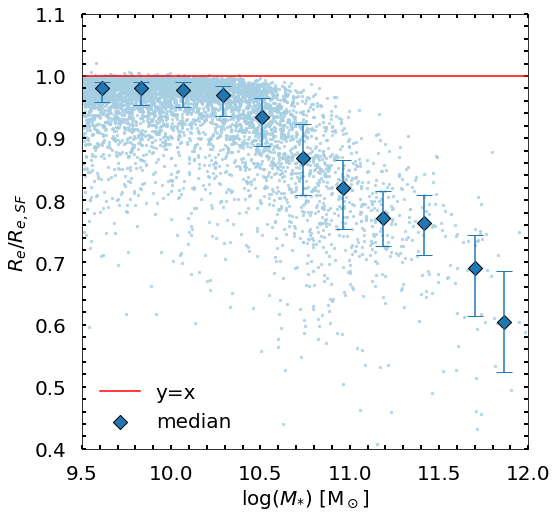

In [10]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMassStellar"].values
old_vals = np.array(old["SubhaloHalfmassRadStellar"].values)
new_vals = np.array(new["SubhaloHalfmassRadStellar"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")
x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_fR(ax=axs, y0=0.4, y1=1.1)


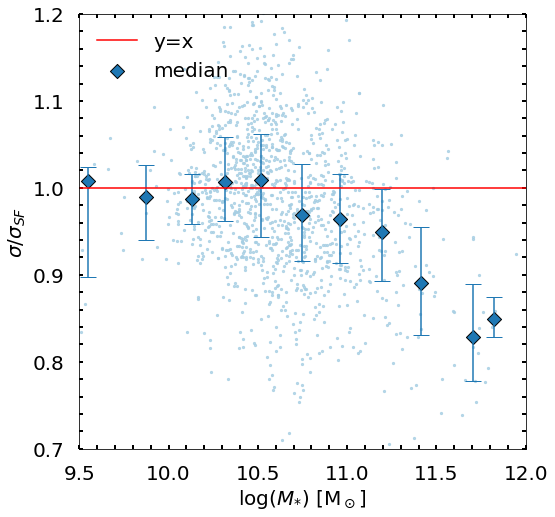

In [11]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_earlies_log["SubhaloMassStellar"].values
old_vals = np.array(old_earlies["SubhaloVelDisp"].values)
new_vals = np.array(new_earlies["SubhaloVelDisp"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_fVD(ax=axs, x0=9.5, x1=12, y0=0.7, y1=1.2)


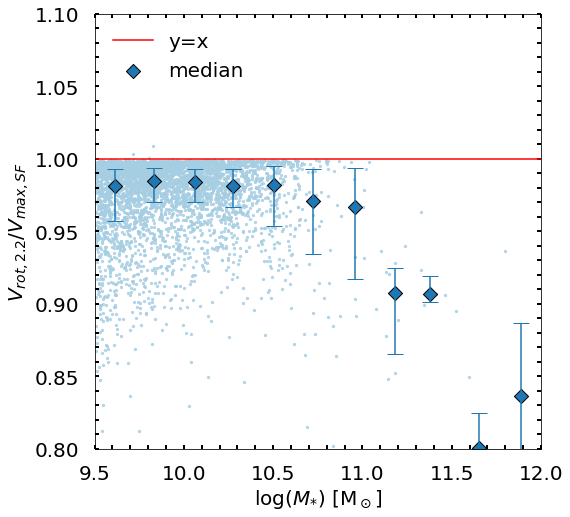

In [12]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_lates_log["SubhaloMassStellar"].values
old_vals = np.array(old_lates["SubhaloVmax"].values)
new_vals = np.array(new_lates["SubhaloRotVel_2_2Re"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 9.5, 12)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_fV(ax=axs, y0=0.8, y1=1.1)


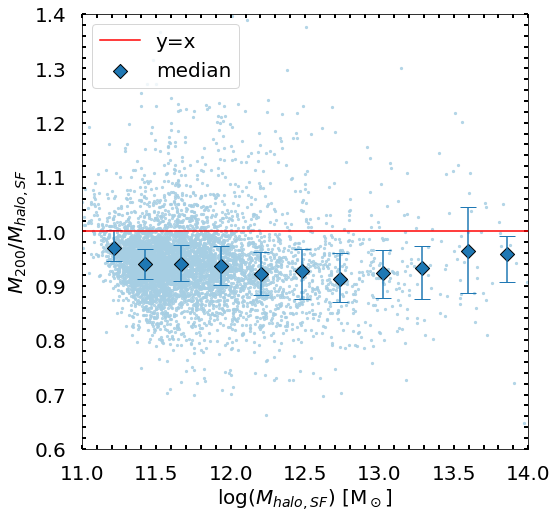

In [13]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
old_vals_log = old_log["SubhaloMass"].values
old_vals = np.array(old["SubhaloMass"].values)
new_vals = np.array(new["SubhaloMass200"].values)
frac = new_vals/old_vals

x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 11, 14)

axs.scatter(old_vals_log, frac, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(0, 16, 2)
y = [1]*2
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.HM_fHM(ax=axs, y0 = 0.6, y1=1.4)


In [14]:
print(new["KineticEnergy"])
print(new["RotationalEnergy"])

0       2.017084e+07
1       3.355069e+07
2       1.849376e+07
3       9.176619e+06
4       1.271679e+07
            ...     
5850    1.958608e+03
5851    2.797601e+03
5852    2.158159e+03
5853    1.804258e+03
5854    1.799089e+03
Name: KineticEnergy, Length: 5855, dtype: float64
0       6.551694e+06
1       9.416431e+06
2       6.202525e+06
3       2.923502e+06
4       3.705185e+06
            ...     
5850    5.851705e+02
5851    1.052880e+03
5852    7.051484e+02
5853    7.113232e+02
5854    6.760421e+02
Name: RotationalEnergy, Length: 5855, dtype: float64


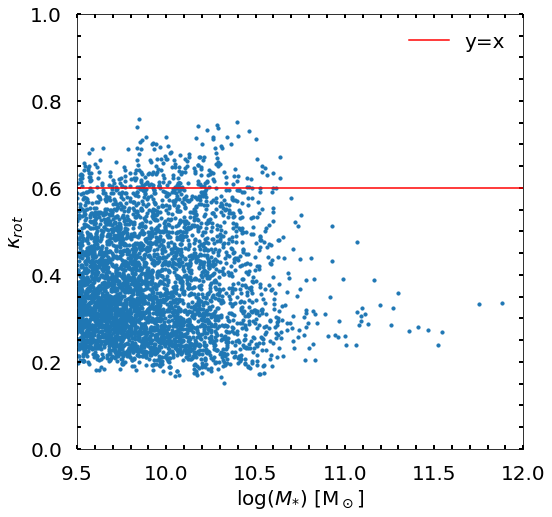

In [20]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
x_vals_log = new_lates_log["SubhaloMassStellar"].values
y_vals = new_lates["Kappa_rot"].values

#x_med, y_med, x_err, y_err = il.stats.median_errors(old_vals_log, frac, 11, 14)

axs.scatter(x_vals_log, y_vals, s=10, alpha=1)
#Plot median values
#axs.errorbar(x_med, y_med, yerr=y_err, capsize = 8, color="#1f78b4", marker='^', fmt = 'none')
#axs.scatter(x_med, y_med, marker='D', s=100, color="#1f78b4", edgecolors = "black", label = r"median")

x = np.linspace(9.5, 12, 2)
y = 2*[0.6]
axs.plot(x, y, c="red", label = "y=x")

il.formatplot.SM_kappa(ax=axs, x0=9.5, x1=12, y0=0, y1 = 1)


In [16]:
gal_flip = new[new["id"] == 518896]
gal_right =  new[new["id"] == 518854]
gal_3 =  new[new["id"] == 518810]
gal_4 =  new[new["id"] == 518774]
gal_5 =  new[new["id"] == 583208]

print(gal_flip["RotationAxisX"].values, gal_flip["RotationAxisY"].values, gal_flip["RotationAxisZ"].values)
print(gal_right["RotationAxisX"].values, gal_right["RotationAxisY"].values, gal_right["RotationAxisZ"].values)
print(gal_3["RotationAxisX"].values, gal_3["RotationAxisY"].values, gal_3["RotationAxisZ"].values)
print(gal_4["RotationAxisX"].values, gal_4["RotationAxisY"].values, gal_4["RotationAxisZ"].values)
print(gal_5["RotationAxisX"].values, gal_5["RotationAxisY"].values, gal_5["RotationAxisZ"].values)

[-0.74344929] [-0.39614756] [0.5388416]
[0.00463782] [-0.0230916] [0.9997226]
[-0.12276583] [0.02991717] [-0.99198463]
[-0.15525436] [-0.49498985] [0.85491586]
[0.01078304] [0.94919402] [0.31450666]


In [25]:
print(new[new["id"]==583208]["Kappa_rot"])

4861    0.278726
Name: Kappa_rot, dtype: float64
